# Advanced Defect Analysis

Here we describe some more targeted analysis you can do for your defect calculations parsed with `doped` (including comparing the relaxed configurations for different initial interstitial positions, structure & bond length analysis of defects, and plotting/analysis of the defect charge corrections), which may be useful for in certain cases.

## Defect-Induced Site Displacements (Strain)

Using the `DefectEntry.plot_site_displacements()` method, we can analyse the displacements of atoms around the defect site (i.e. defect-induced local strain) during geometry relaxation.

In [6]:
%matplotlib inline
from monty.serialization import loadfn
CdTe_defects_thermo = loadfn("CdTe_thermo_wout_meta.json")  # load our DefectThermodynamics object

Let's look at the displacements of atoms around the Cd vacancy in CdTe, and how this changes with charge state:

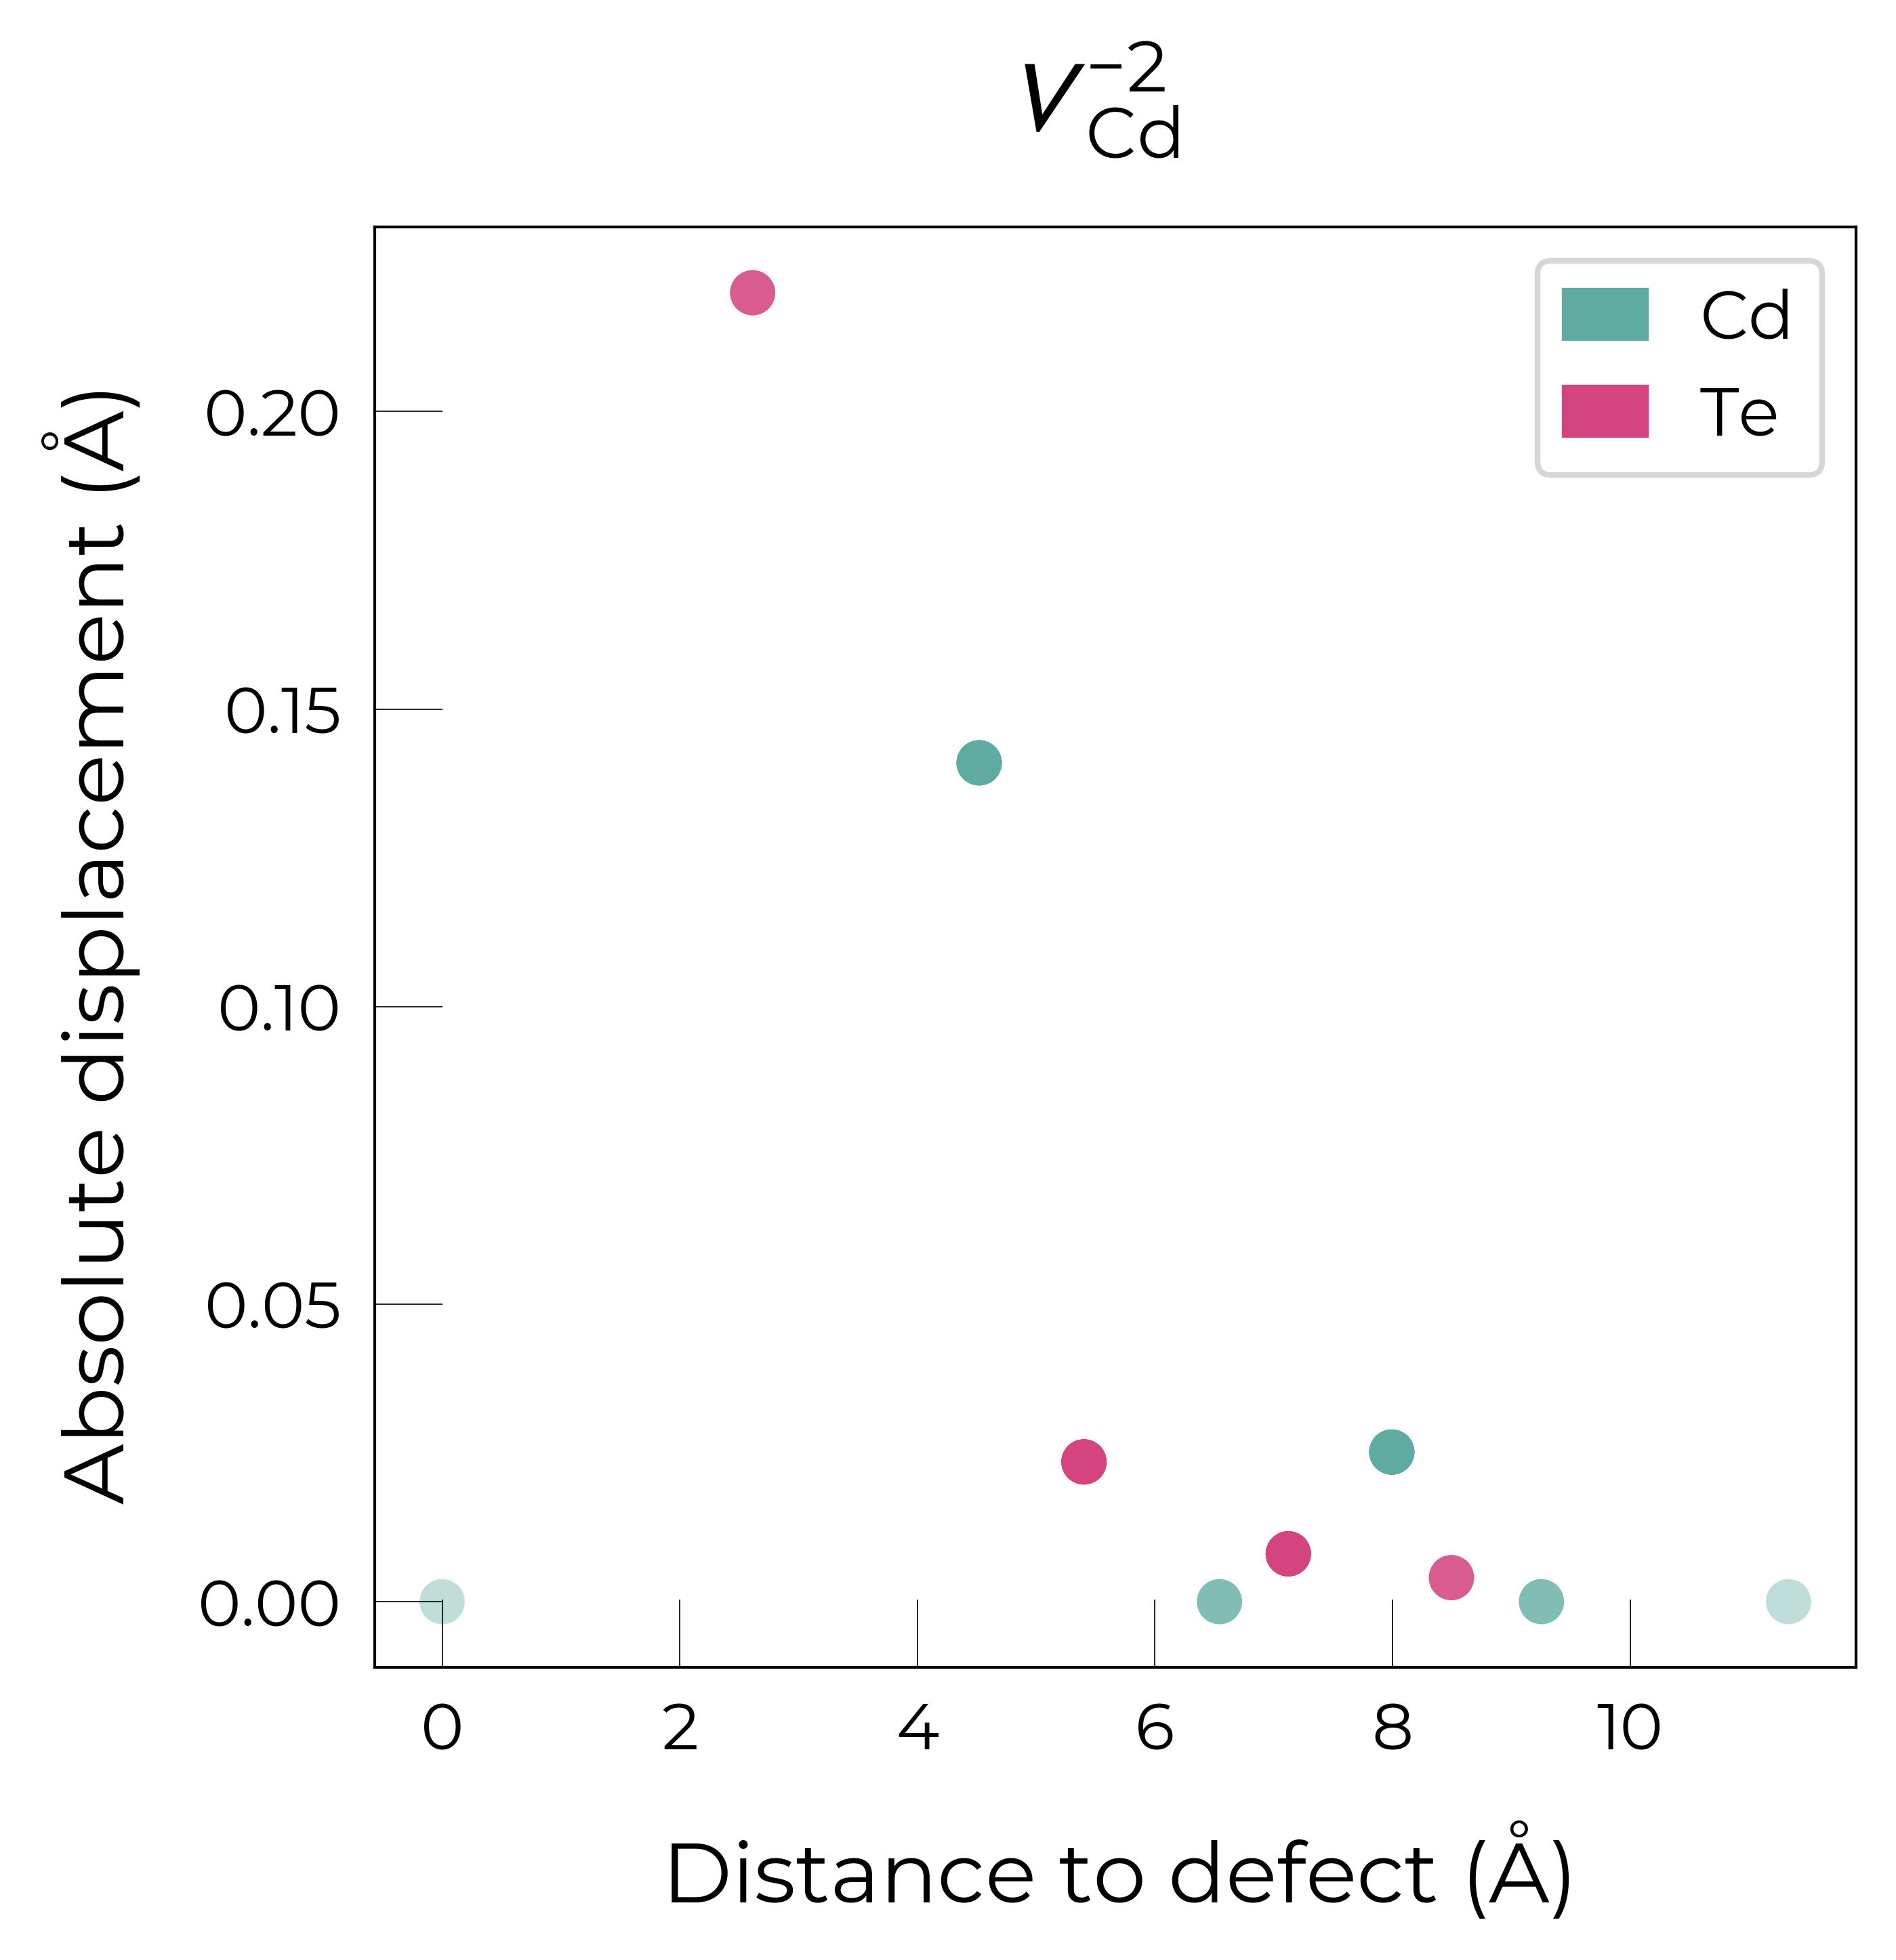

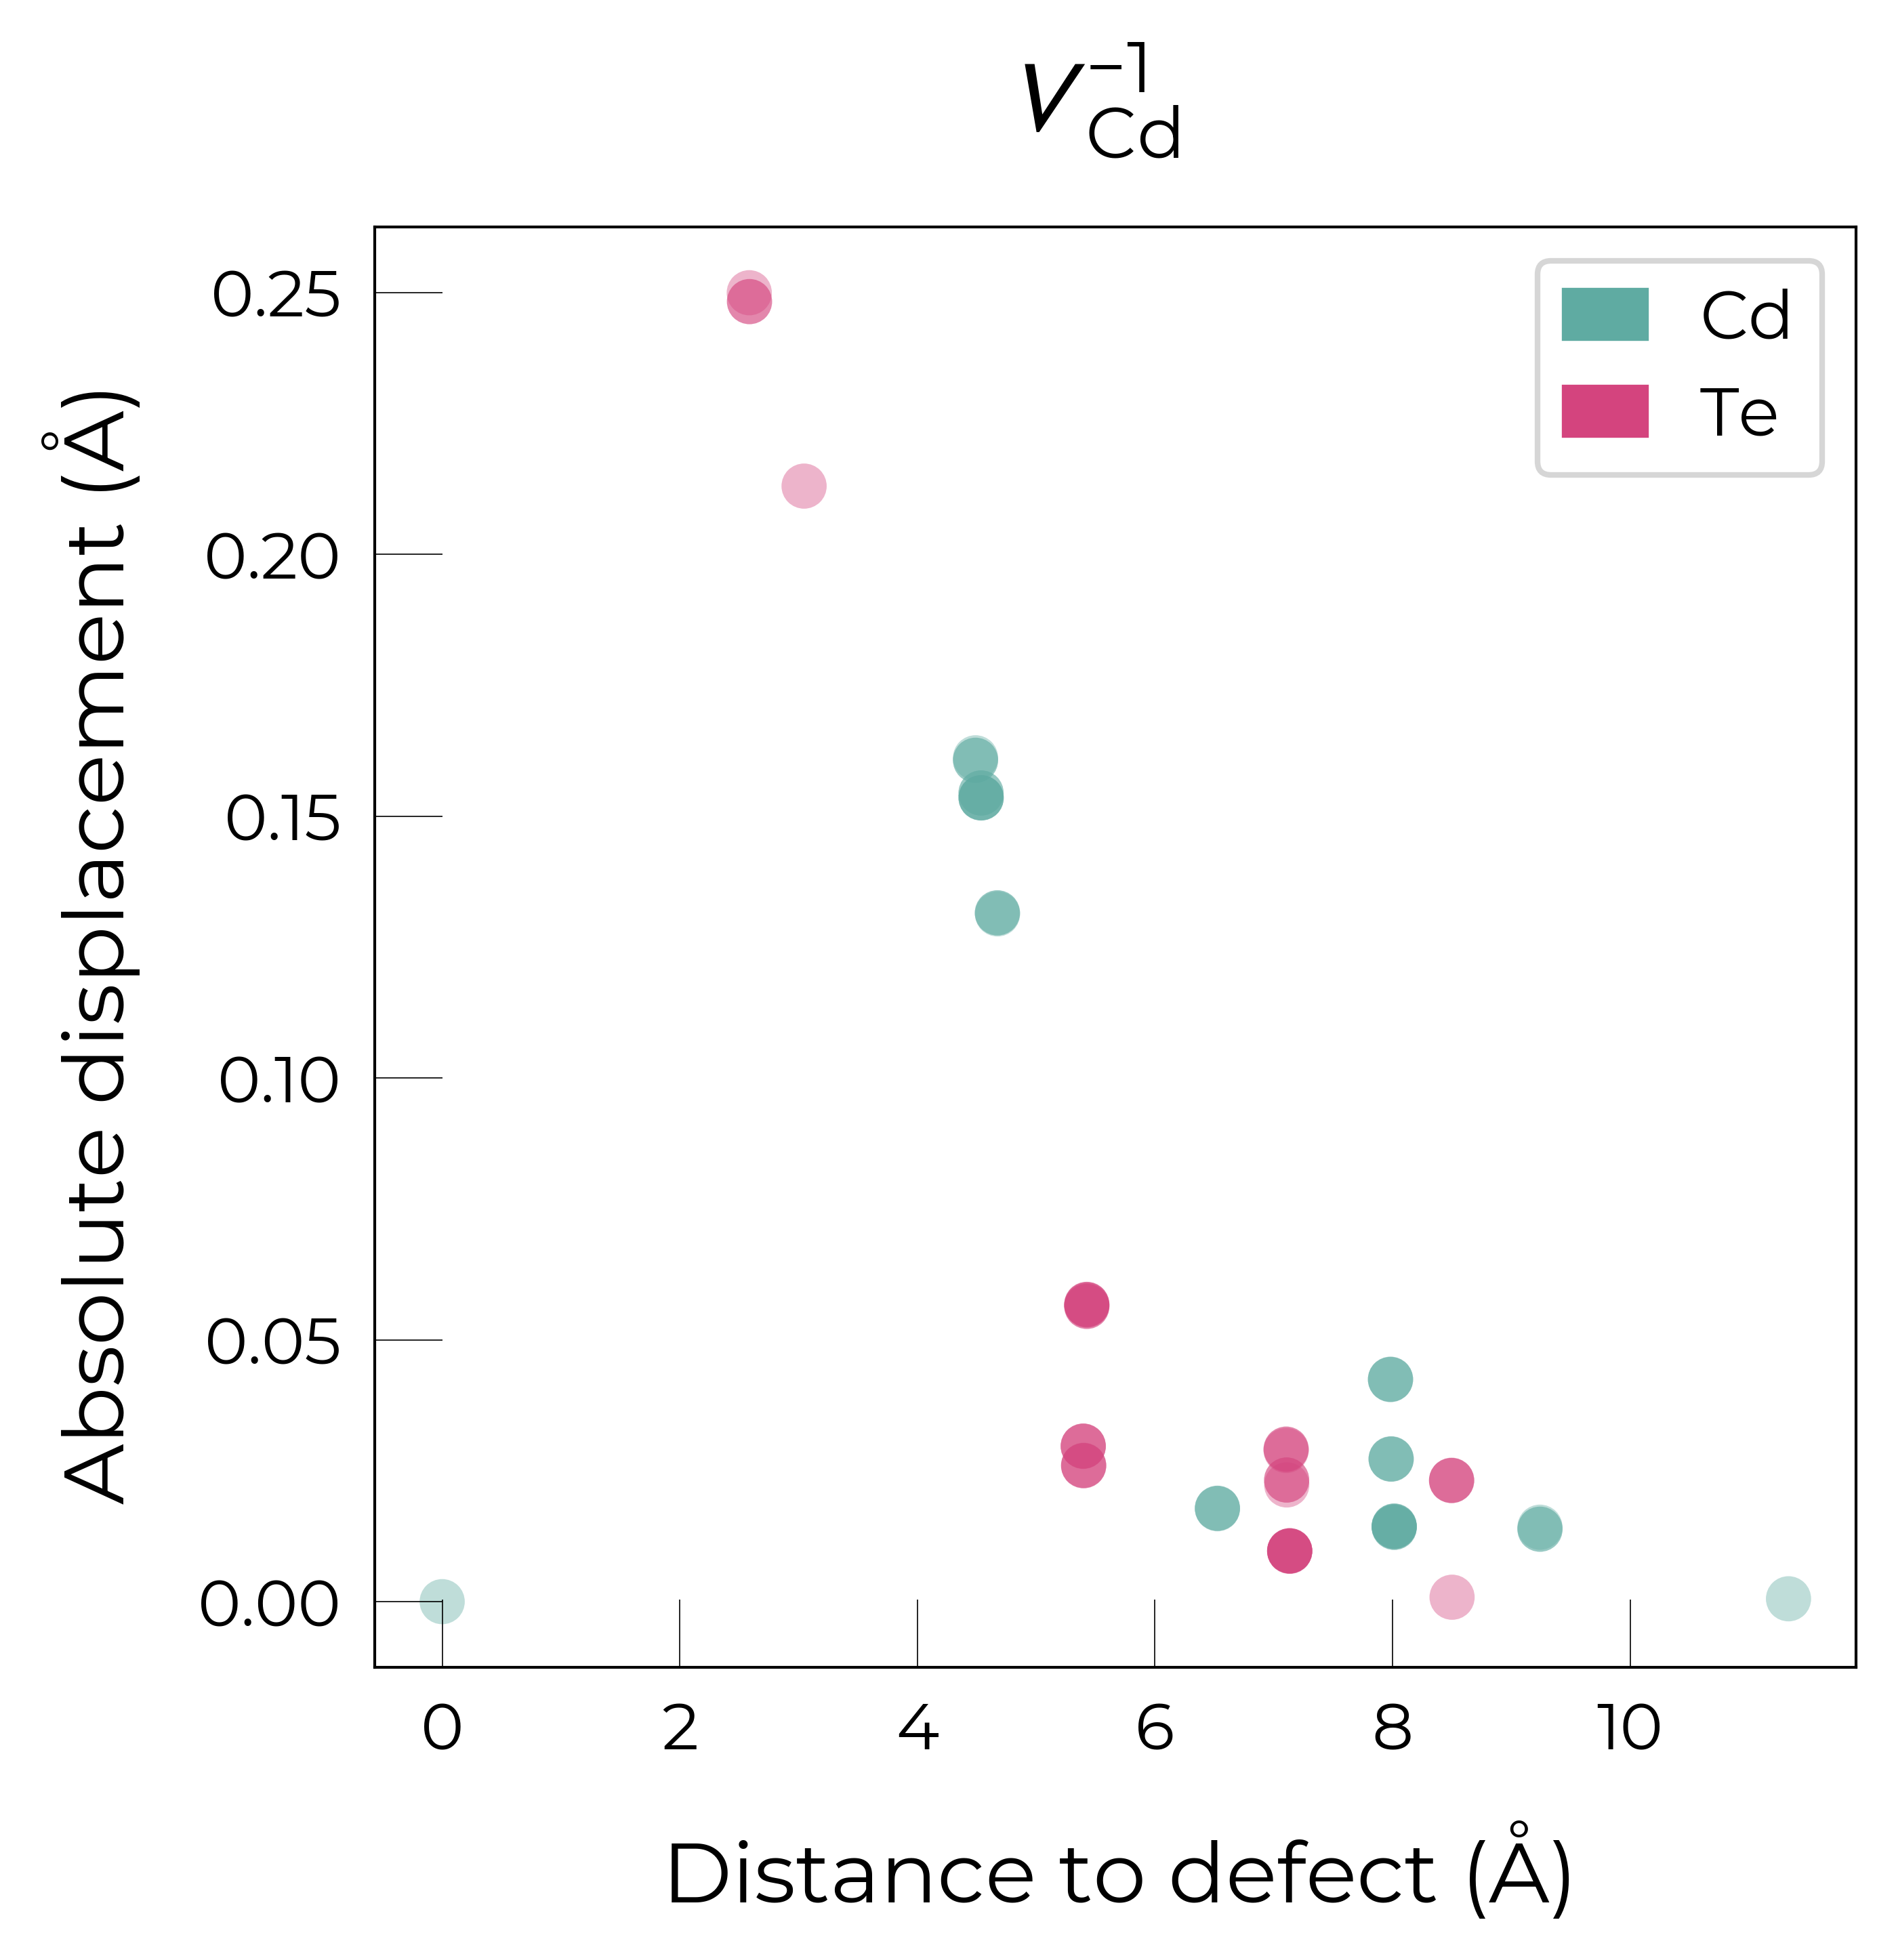

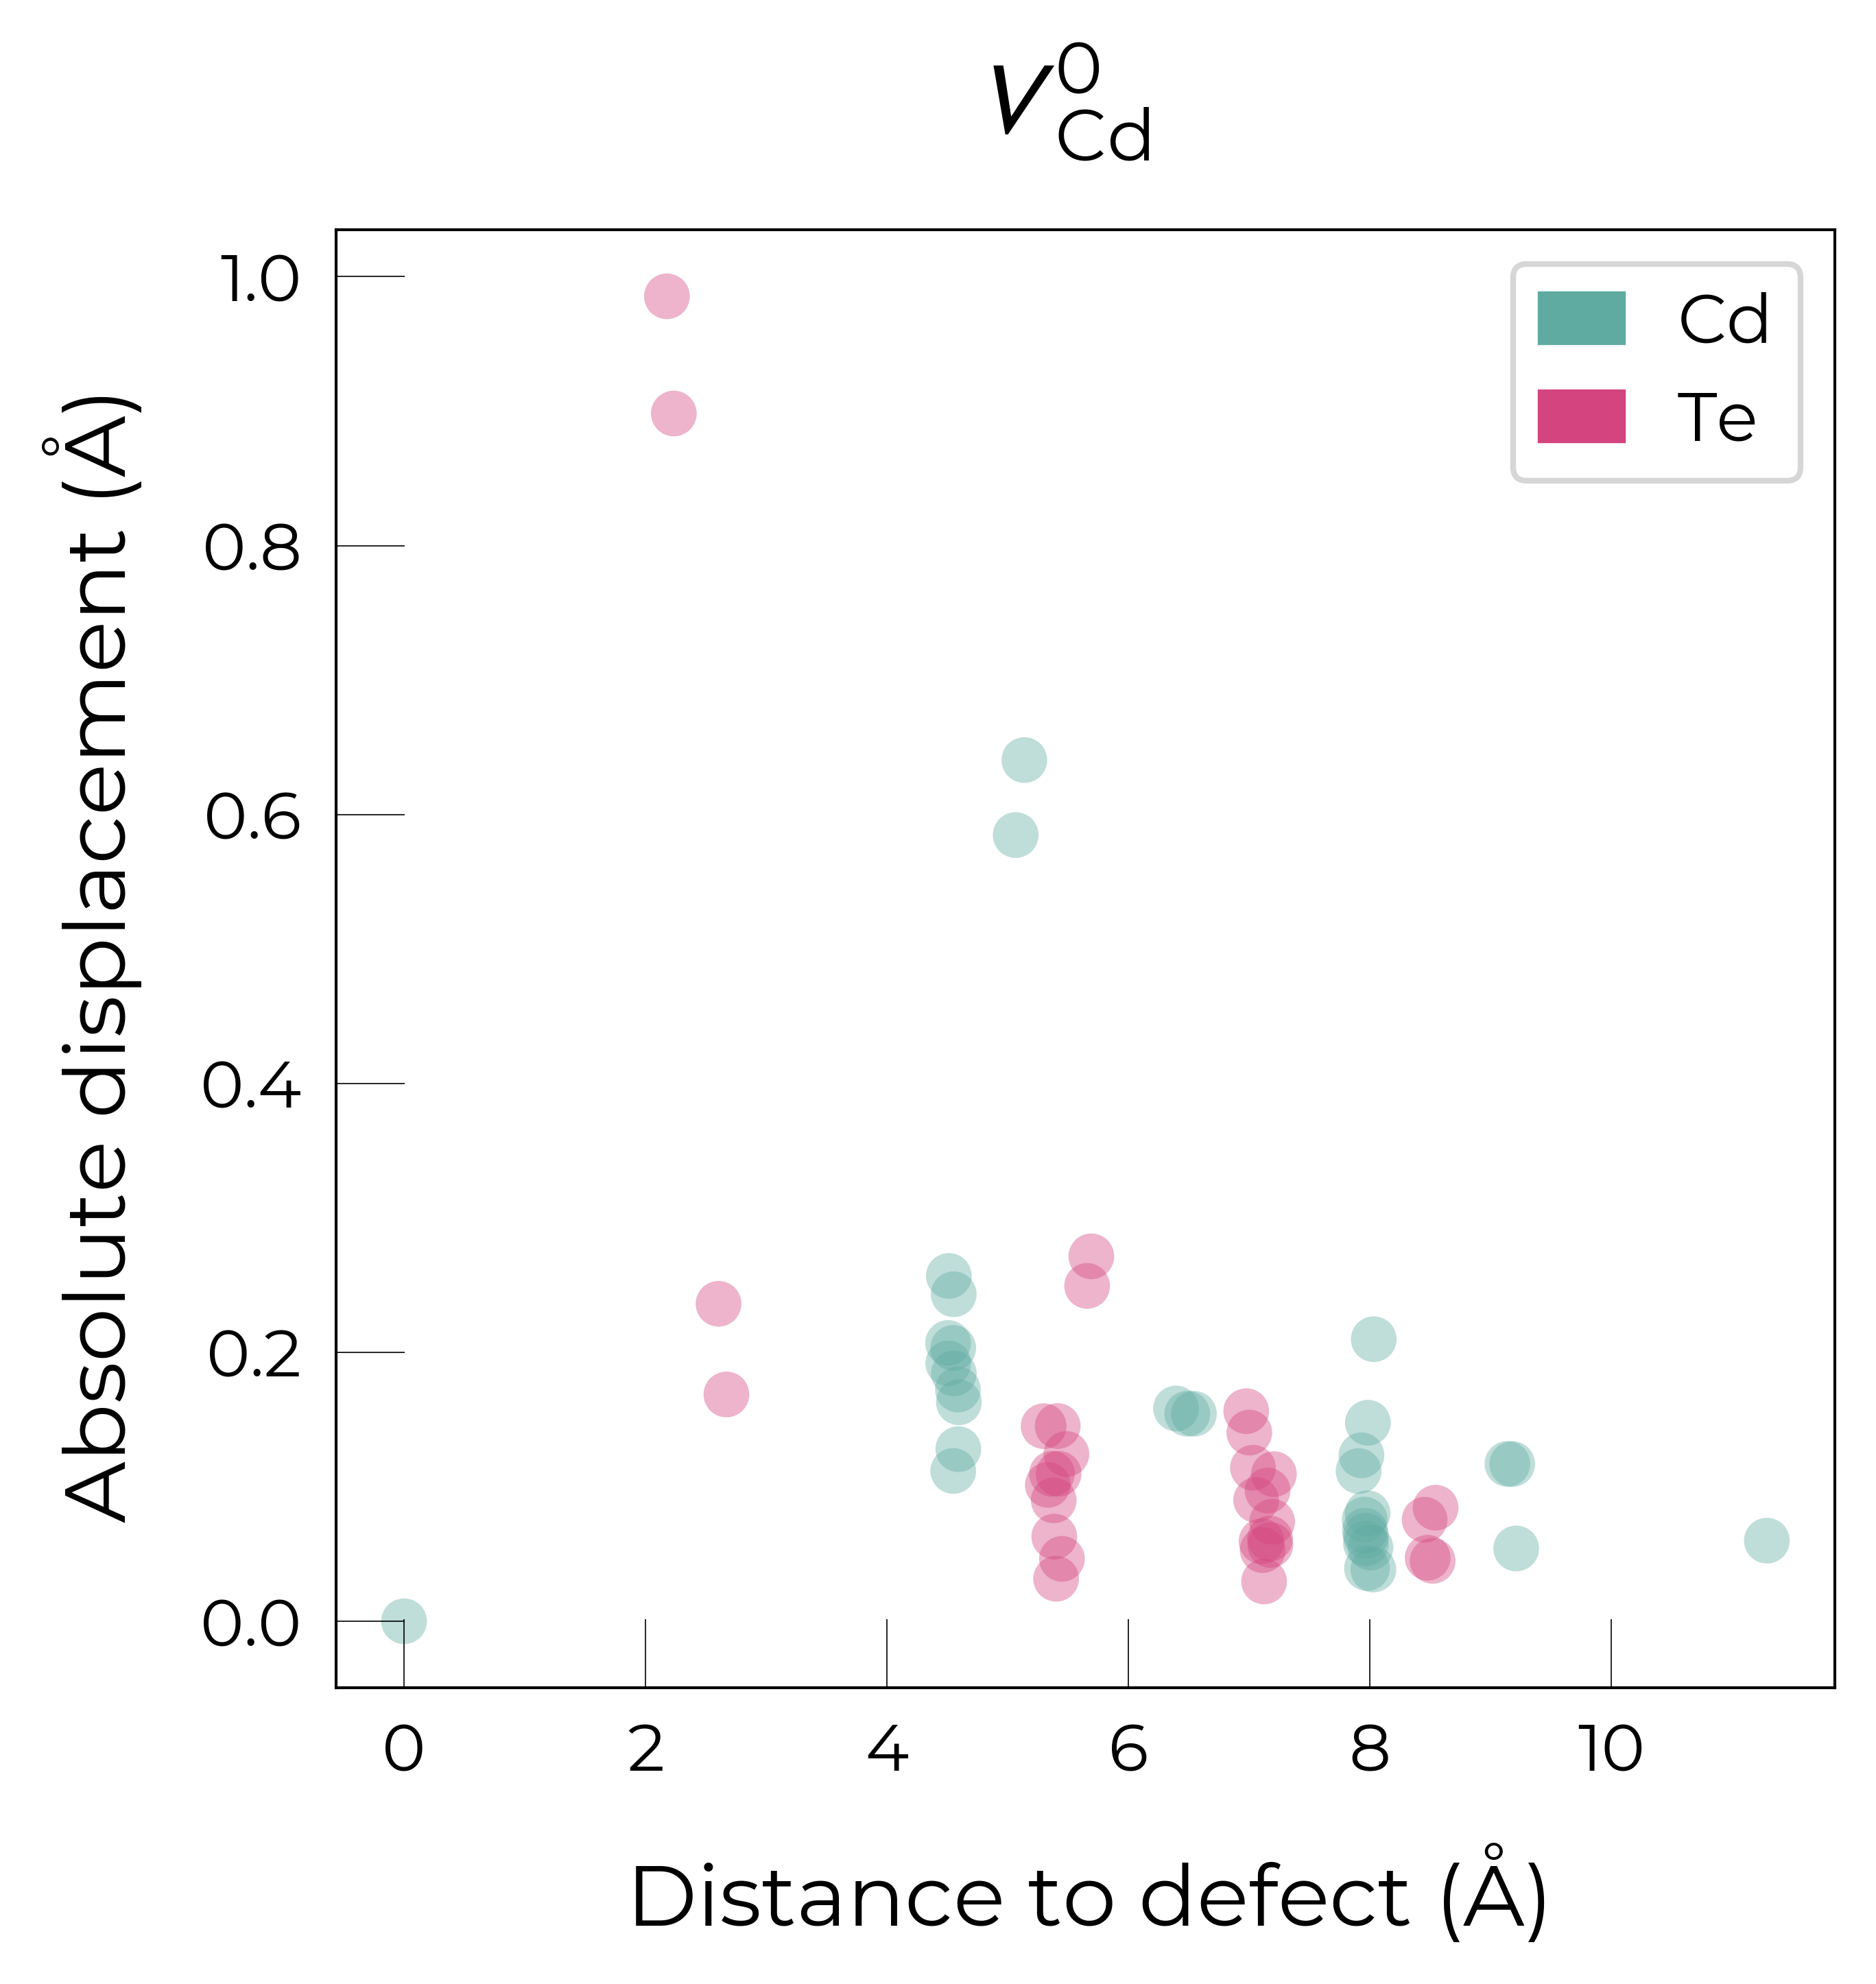

In [35]:
from doped.utils.plotting import _format_defect_name

v_Cd_entries = [entry for entry in CdTe_defects_thermo.defect_entries if "v_Cd" in entry.name]
for defect_entry in v_Cd_entries:
    fig = defect_entry.plot_site_displacements(separated_by_direction=False)
    fig.suptitle(_format_defect_name(defect_entry.name, include_site_info_in_name=False), 
                 fontsize=18)

Separated by direction:

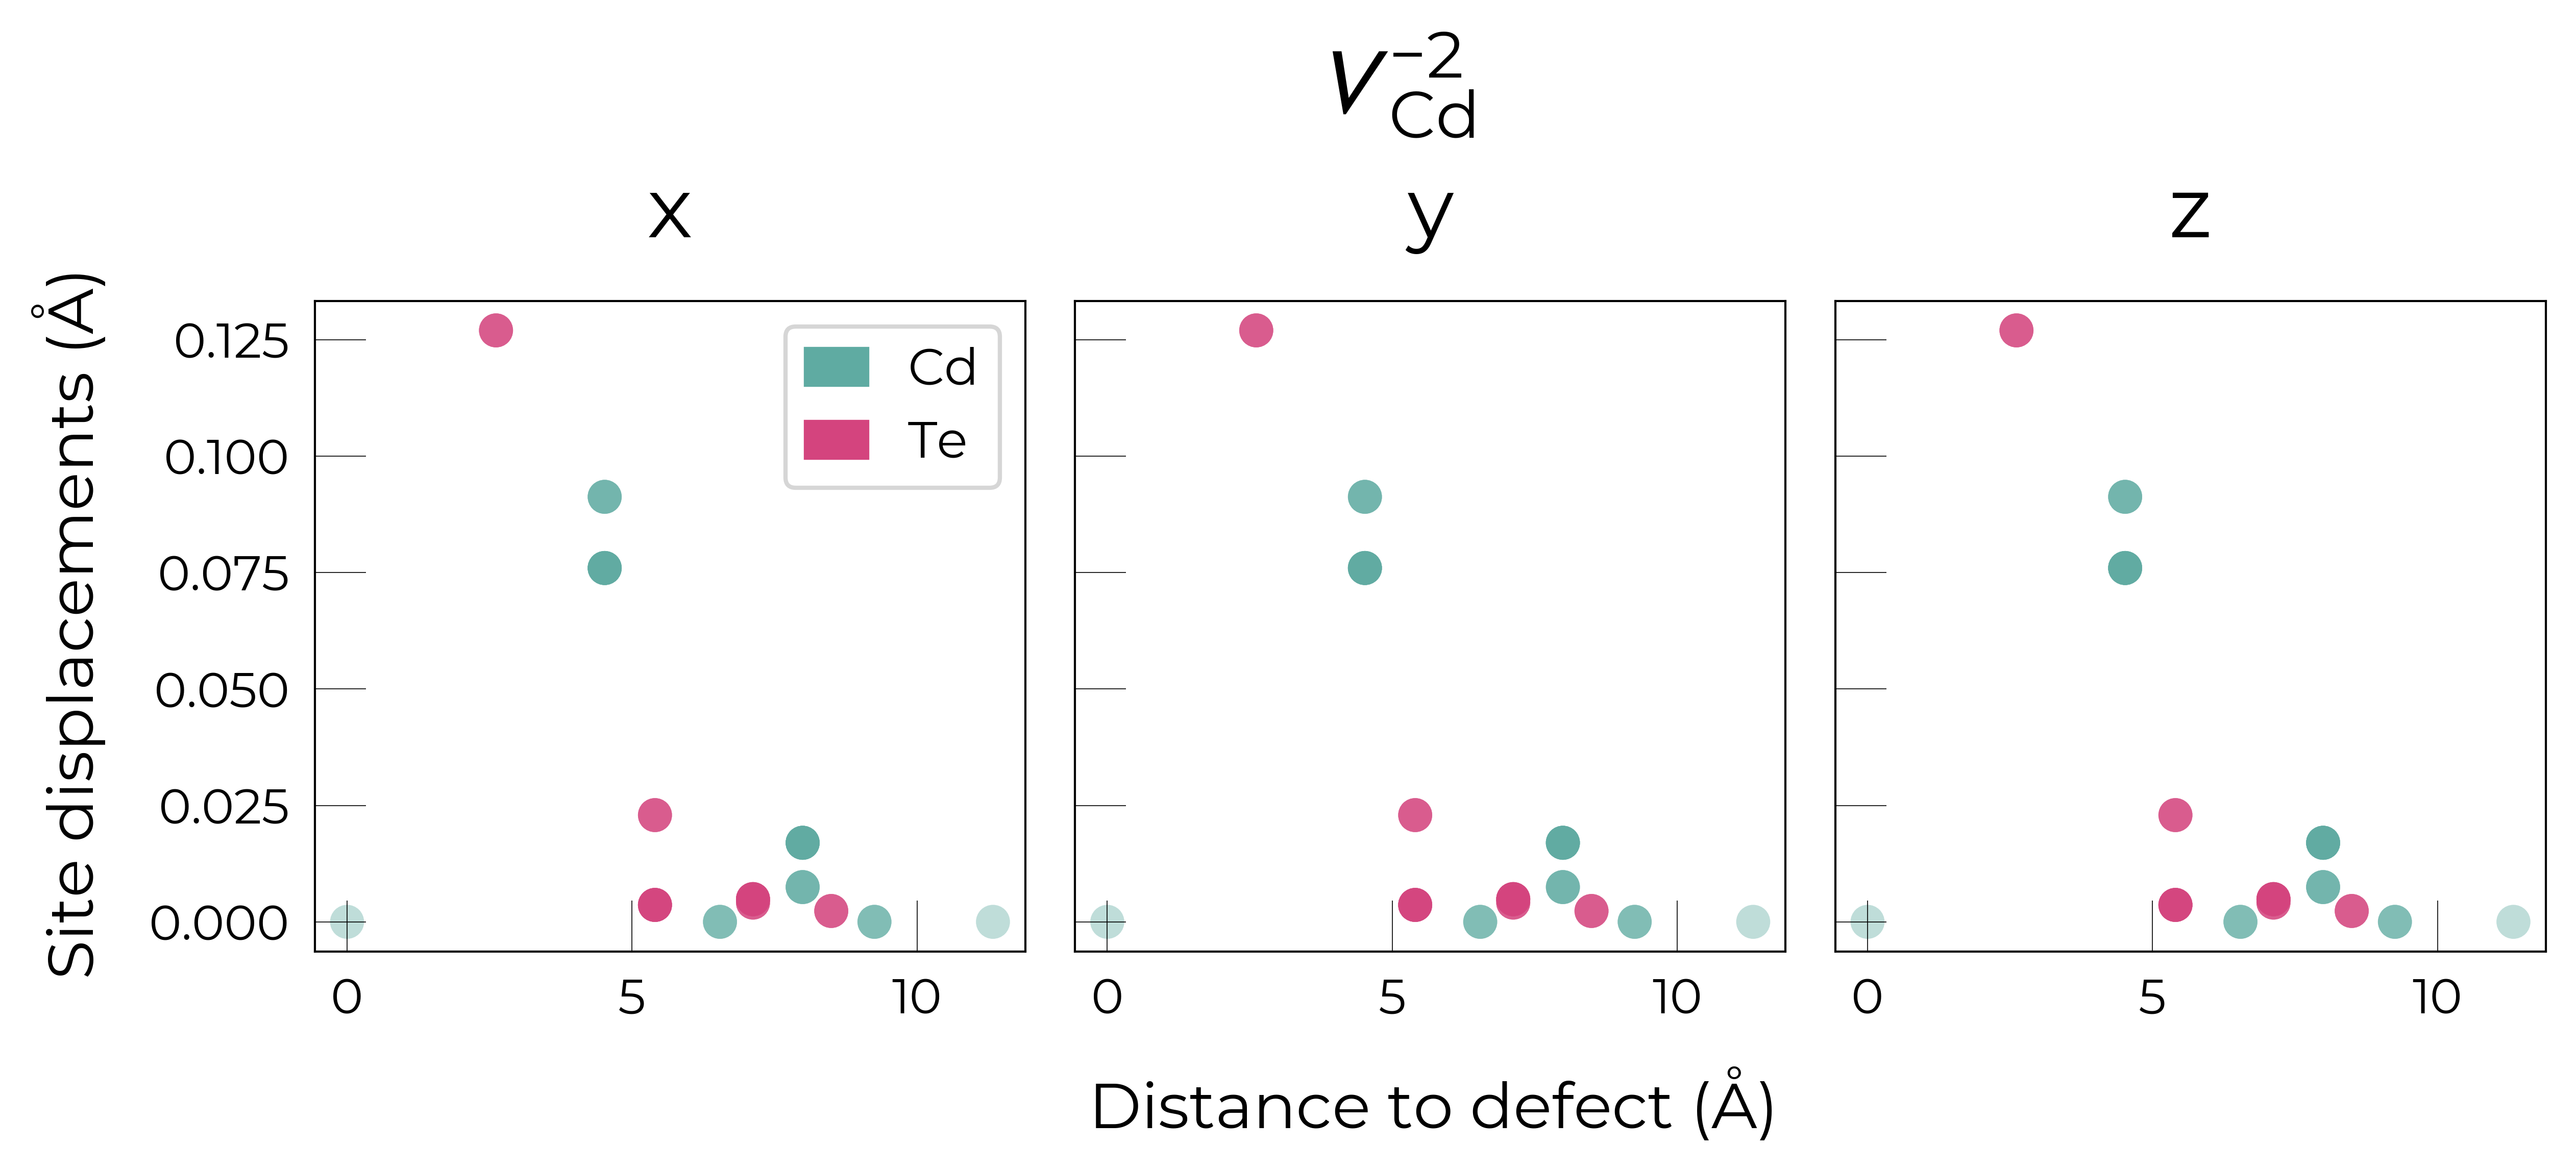

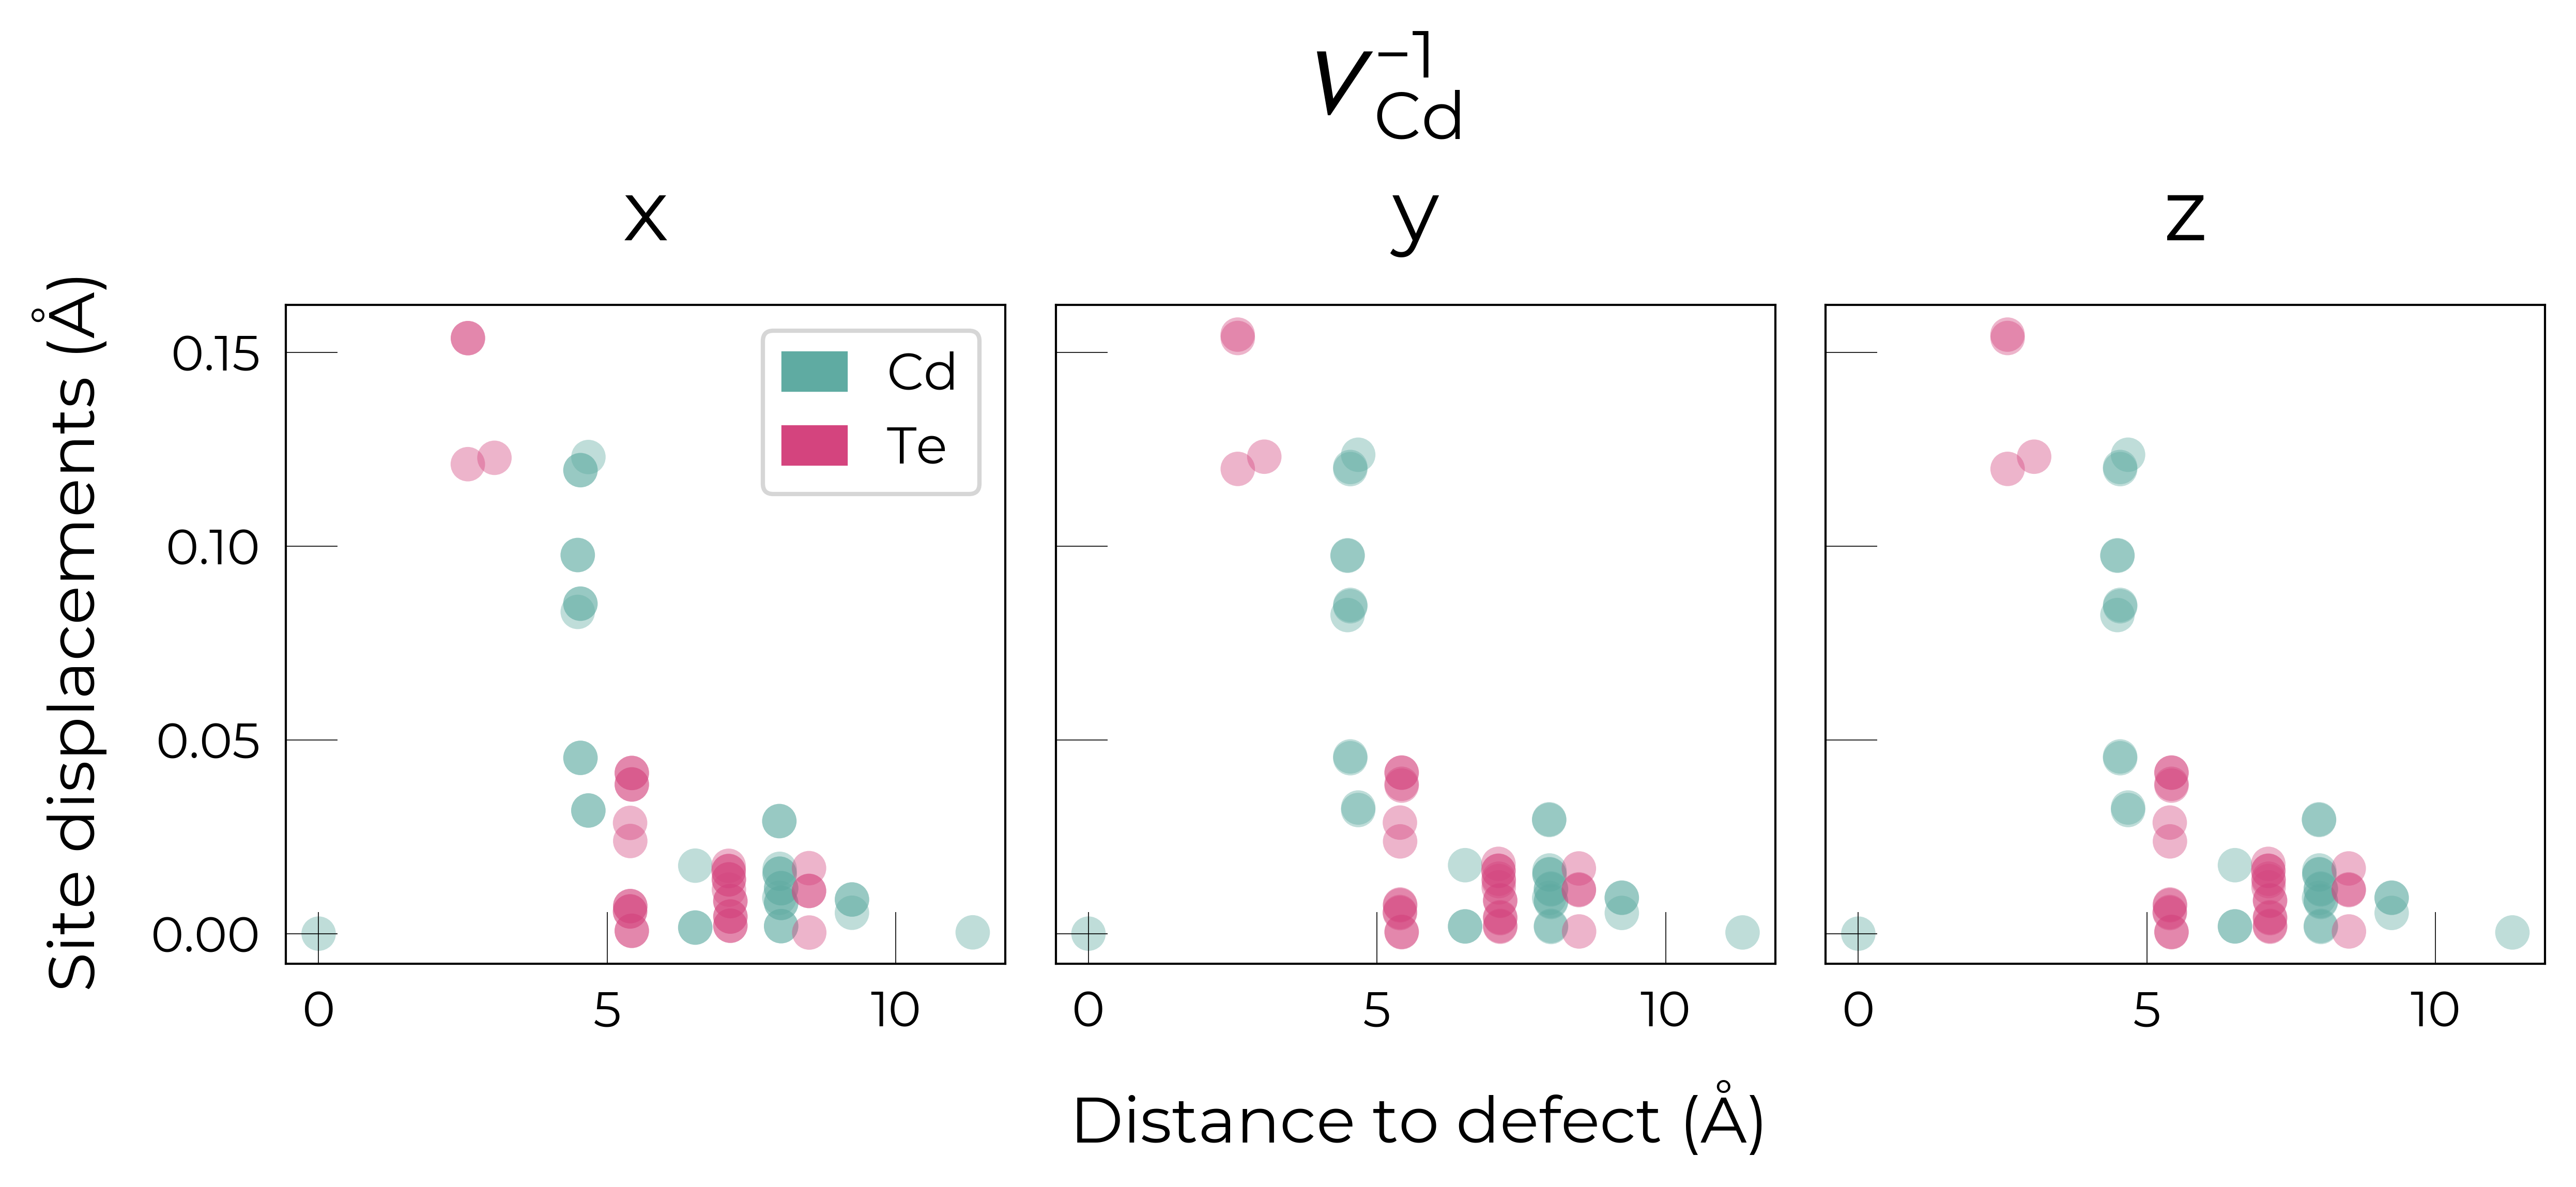

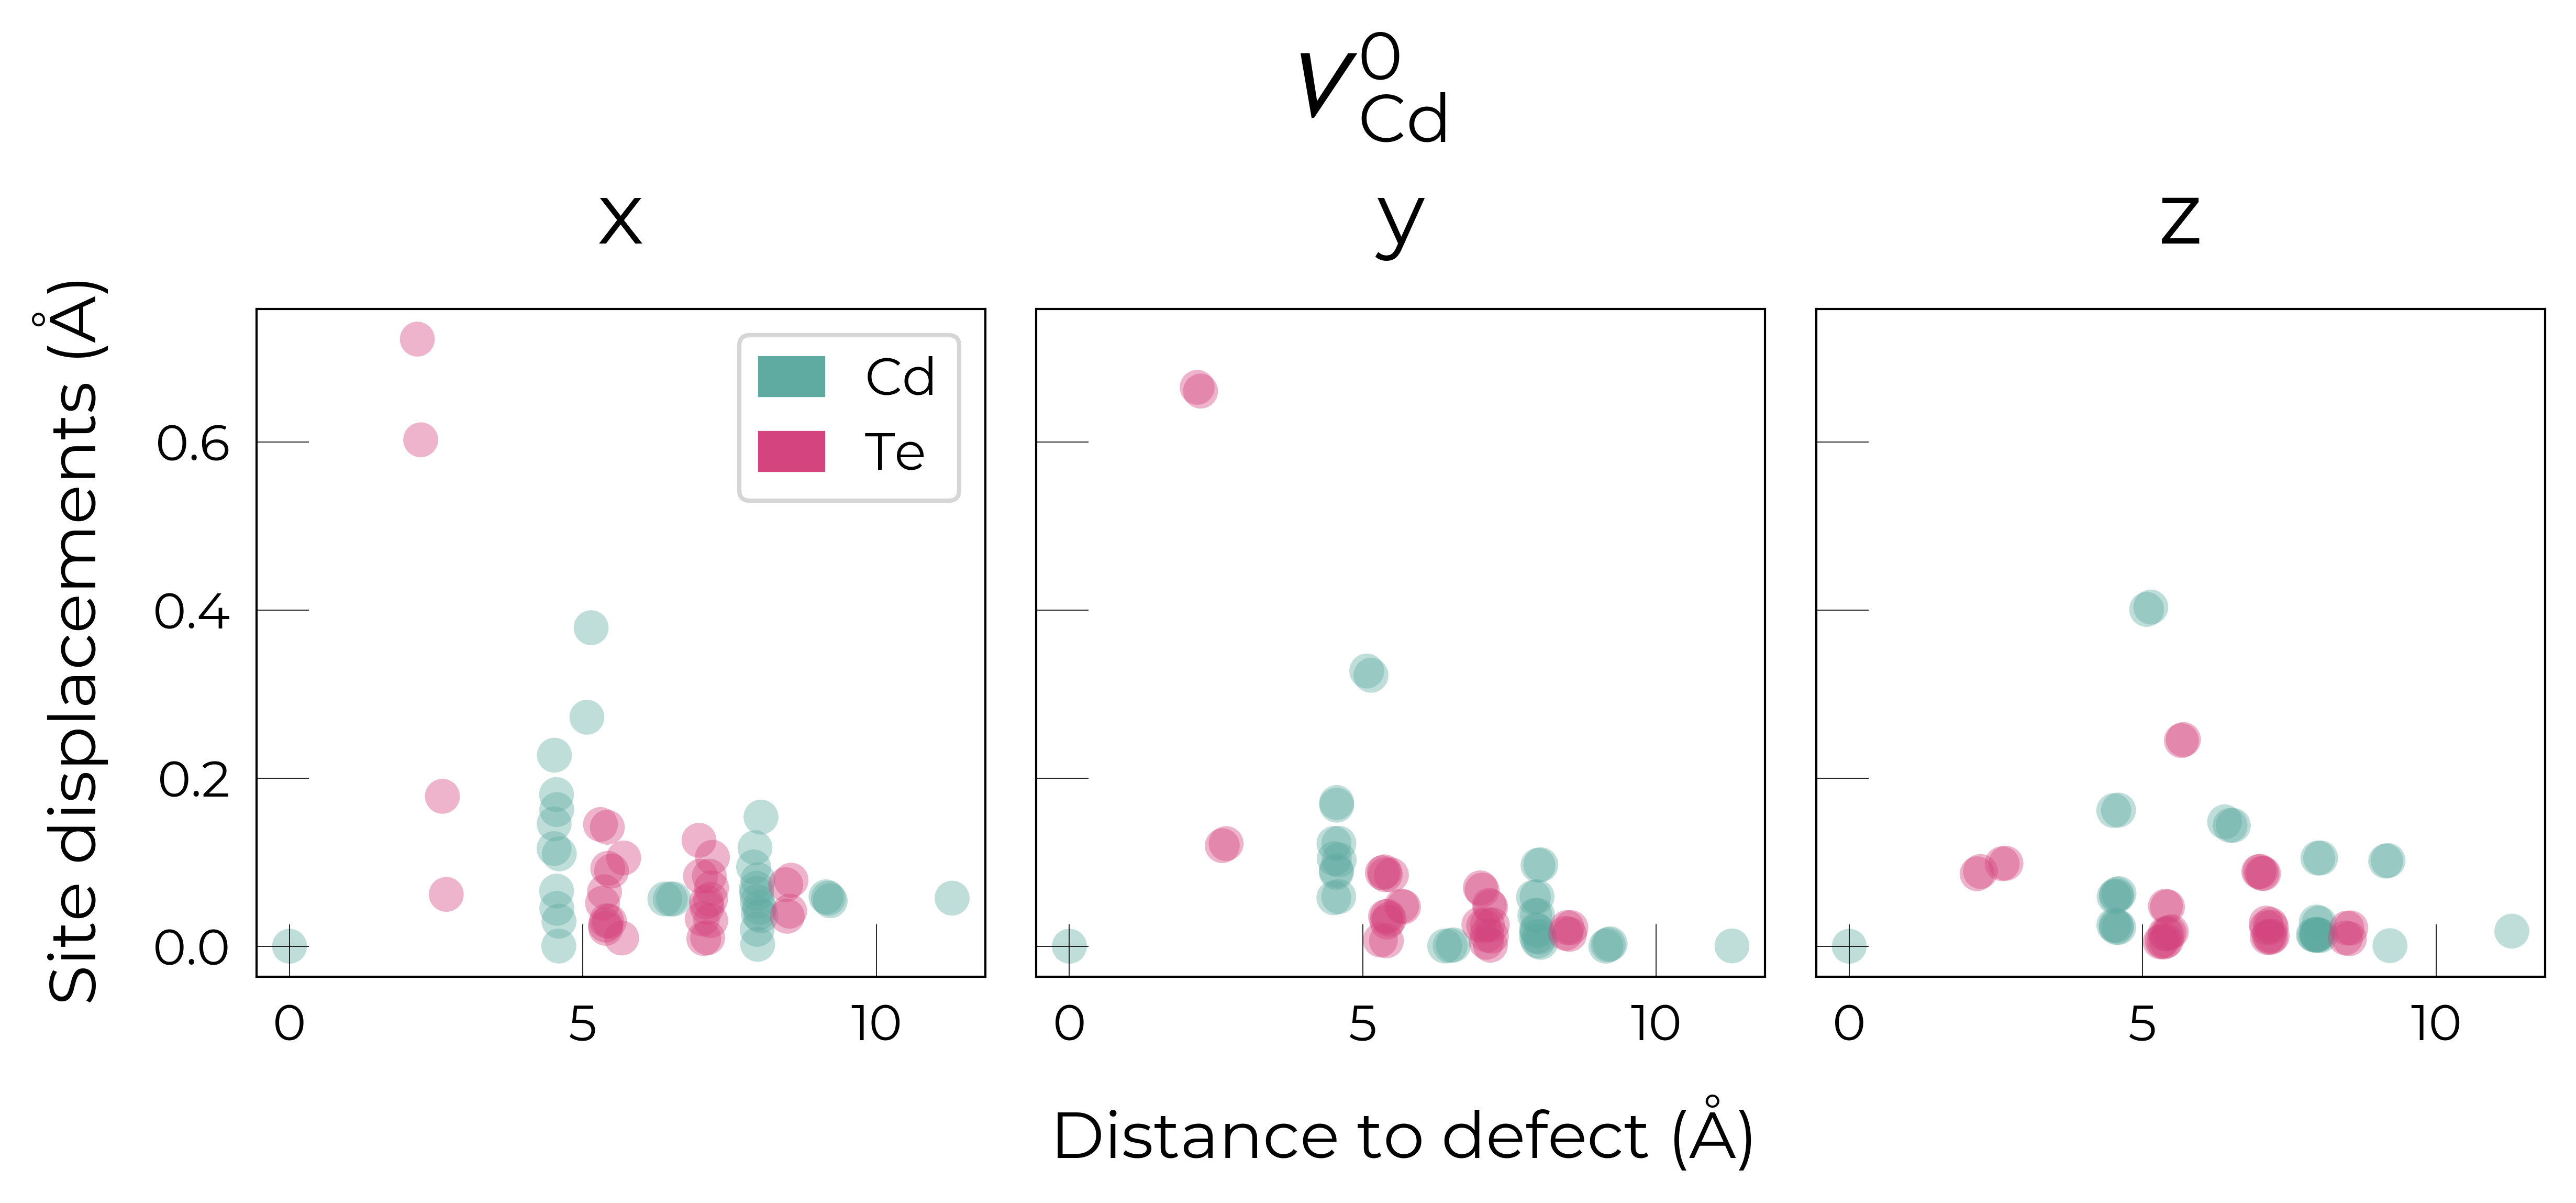

In [27]:
from doped.utils.plotting import _format_defect_name

v_Cd_entries = [entry for entry in CdTe_defects_thermo.defect_entries if "v_Cd" in entry.name]
for defect_entry in v_Cd_entries:
    fig = defect_entry.plot_site_displacements()
    fig.suptitle(_format_defect_name(defect_entry.name, include_site_info_in_name=False), 
                 y=1.2, fontsize=22)

Here we see that $V_{Cd}^{-2}$ has isotropic (symmetric) displacements of atoms around the vacancy site in the x/y/z directions, which makes sense as it adopts a tetrahedral (`Td`) geometry (as shown in the `get_symmetries_and_degeneracies` output below and discussed in detail in [this paper](https://pubs.acs.org/doi/10.1021/acsenergylett.1c00380)).
As expected, we see an exponential tail-off in the site displacement magnitudes as we move away from the defect, and it is the Te nearest neighbours which are most strongly perturbed.

For $V_{Cd}^{-1}$, we have a [Jahn-Teller-distorted](https://pubs.acs.org/doi/10.1021/acsenergylett.1c00380) $C_{3v}$ geometry where a neighbouring Te atom displaces along the [111] direction away from the vacancy site (while the other Te atoms displace away from the vacancy but by a smaller degree), while for $V_{Cd}^{0}$, we have a $C_{2v}$ geometry where two neighbouring Te displace significantly toward eachother (~1 Å) and form a dimer bond, while the other two Te move a smaller distance away (~0.2 Å) as seen in the displacement plots.

In [28]:
from doped.thermodynamics import DefectThermodynamics
v_Cd_thermo = DefectThermodynamics(v_Cd_entries)
v_Cd_thermo.get_symmetries_and_degeneracies()

,Defect,q,Site_Symm,Defect_Symm,g_Orient,g_Spin,g_Total,Mult
0,v_Cd,-2,Td,Td,1.0,1,1.0,1.0
1,v_Cd,-1,Td,C3v,4.0,2,8.0,1.0
2,v_Cd,0,Td,C2v,6.0,1,6.0,1.0


The high symmetry of $V_{Cd}^{-2}$ is evident from the displacement plots above, where it looks like there are much fewer atoms in the plots, however this is just because we have many symmetry-equivalent atoms in this case and so we end up with many overlapping points (and so much less distinct points). Then for $C_{3v}$ $V_{Cd}^{-1}$ we have more distinct sites appearing, and then more so for the lower-symmetry $C_{2v}$ $V_{Cd}^{0}$ structure.

## Processing Cdᵢ `vasp_gam` calculations to see which site is favoured

In [14]:
import os
from doped.analysis import DefectParser

bulk_path = "CdTe/CdTe_bulk/vasp_gam/"  # path to bulk (defect-free) supercell calculation
dielectric = 9.13  # calculated dielectric constant, required for computing defect charge corrections
Cd_i_dict = {}  # Keep dictionary of parsed defect entries

for i in os.listdir("CdTe"):
    if 'Cd_i' in i:
        Cd_i_dict[i] = DefectParser.from_paths(
            defect_path=f"CdTe/{i}/vasp_gam/", bulk_path=bulk_path, dielectric=dielectric).defect_entry

for defect_name, defect_entry in Cd_i_dict.items():
    print(f"Name: {defect_name}; Raw Supercell Energy: {defect_entry.get_ediff():.3f} eV")
    # note this energy is just the energy difference of the bulk and defect supercells (including 
    # finite-size charge corrections if any – none here as they're neutral defects), without Fermi
    # level or chemical potential terms (though these are constant for the same defect & charge)

Name: Cd_i_Td_Cd2.83_0; Raw Supercell Energy: 0.592 eV
Name: Cd_i_C3v_0; Raw Supercell Energy: 0.728 eV
Name: Cd_i_Td_Te2.83_0; Raw Supercell Energy: 0.728 eV


Here we see that the Cd-coordinated interstitial site is the lowest energy for _neutral_ cadmium
interstitials here!

```{note}
The energies here do not yet account for the chemical potentials, which are included later in the
post-processing workflow (as shown earlier in this notebook). However, the chemical potential energy
correction is the same for each charge state or site, for a **_given defect_** (e.g. Cd<sub>i</sub>
here) - hence the relative energies are still meaningful here.
```

Here we see that `Cd_i_C3v_0` and `Cd_i_Td_Te2.83_0` have equal final energies (rounded to 1 meV/atom)
suggesting they have relaxed to the same final structure (despite different initial interstitial positions).
Let's use `StructureMatcher` and `local_env` to double-check:

In [24]:
# Here we use the pymatgen StructureMatcher class to compare the relaxed structures of neutral Cd_i:
from pymatgen.analysis.structure_matcher import StructureMatcher
sm = StructureMatcher()
print("Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_Td_Cd2.83_0'].defect_supercell, Cd_i_dict['Cd_i_C3v_0'].defect_supercell))
print("Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?:",
      sm.fit(Cd_i_dict['Cd_i_C3v_0'].defect_supercell, Cd_i_dict['Cd_i_Td_Te2.83_0'].defect_supercell))

Are Cd_i_Td_Cd2.83_0 and Cd_i_C3v_0 final structures the same?: False
Are Cd_i_C3v_0 and Cd_i_Td_Te2.83_0 final structures the same?: True


In [41]:
# we can perform further defect structural analysis with these functions:
from pymatgen.analysis.local_env import CrystalNN
import numpy as np

for key, defect_entry in Cd_i_dict.items():
    # get defect site index in structure: (needed for CrystalNN)
    for i, site in enumerate(defect_entry.defect_supercell.sites):
        if np.isclose(site.frac_coords, defect_entry.defect_supercell_site.frac_coords).all():
            isite = i  # site index, starting from 0

    crystalNN = CrystalNN()
    struct = defect_entry.defect_supercell
    struct.add_oxidation_state_by_guess()
    print("Local order parameters (i.e. resemblence to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ",
          crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct, isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ", bond_lengths, "\n")

Local order parameters (i.e. resemblence to given structural motif):  None
Nearest-neighbour dictionary:  {'Te0+': 6, 'Cd0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Te', 'Distance': '3.298'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}, {'Element': 'Cd', 'Distance': '3.007'}] 

Local order parameters (i.e. resemblence to given structural motif):  {'square co-planar': 0.08049643519922586, 'tetrahedral': 0.9999935468913711, 'rectangular see-saw-like': 0.007133072179242341, 'see-saw-like': 0.23547633536015408, 'trigonal pyramidal': 0.24644908542744104}
Nearest-neighbour dictionary:  {'Te0+': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.911'}, {'Ele

Here we see the structural similarity of "`Cd_i_C3v_0`" and "`Cd_i_Td_Te2.83_0`", showing that they have
 indeed relaxed to the same structure.
This means we only need to continue with one of these for the more expensive `vasp_std` and `vasp_ncl`
calculations with our full _k_-point mesh.

```{note}
If you want to do this coordination environment analysis with a vacancy, you may have to
introduce a fake atom at the vacancy position, in order to create a `pymatgen` `Site` object, to then use with `CrystalNN`.
For example:
```

In [24]:
from doped.thermodynamics import DefectThermodynamics
v_Cd_thermo = DefectThermodynamics(
    [entry for entry in CdTe_example_thermo.defect_entries if "v_Cd" in entry.name], 
    chempots=CdTe_example_thermo.chempots
)  # only Cd vacancy defects

In [28]:
from pymatgen.analysis.local_env import CrystalNN
from doped.thermodynamics import bold_print

for defect_entry in v_Cd_thermo.defect_entries:
    bold_print(f"{defect_entry.name}, Charge State: {defect_entry.charge_state}")
    crystalNN = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0, porous_adjustment=False, search_cutoff=5)
    struct = defect_entry.defect_supercell.copy()
    struct.append('U', defect_entry.defect_supercell_site.frac_coords) # Add a fake element
    isite = len(struct.sites) - 1 # Starts counting from zero!

    print("Local order parameters (i.e. resemblance to given structural motif): ",
          crystalNN.get_local_order_parameters(struct, isite))
    print("Nearest-neighbour dictionary: ", crystalNN.get_cn_dict(struct, isite))

    bond_lengths = []  # Bond Lengths?
    for i in crystalNN.get_nn_info(struct,isite):
        bond_lengths.append({'Element': i['site'].specie.as_dict()['element'],
                             'Distance': f"{i['site'].distance(struct[isite]):.3f}"})
    print("Bond-lengths (in Angstrom) to nearest neighbours: ",bond_lengths,"\n")

v_Cd_-2, Charge State: -2
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.07996848894580866, 'tetrahedral': 0.999999999996243, 'rectangular see-saw-like': 0.007024644113827354, 'see-saw-like': 0.23425369905750856, 'trigonal pyramidal': 0.24520967518806777}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}, {'Element': 'Te', 'Distance': '2.613'}] 

v_Cd_-1, Charge State: -1
Local order parameters (i.e. resemblance to given structural motif):  {'square co-planar': 0.08955199275710107, 'tetrahedral': 0.9980437792997895, 'rectangular see-saw-like': 0.00914205834683717, 'see-saw-like': 0.2561471898083992, 'trigonal pyramidal': 0.2673736880526364}
Nearest-neighbour dictionary:  {'Te': 4}
Bond-lengths (in Angstrom) to nearest neighbours:  [{'Element': 'Te', 'Distance': '2.585'}, {'Element'